# GO vs. Keywords for substrates

Up until now, we have been using Uniprot keywords for annotations. In order to get all transmembrane transporters of Sugar, we filter the proteins in the dataset by the keywords "Transmembrane" and "Sugar transport". 

This works most of the time, but sometimes there is a small number of proteins that fulfils these requirements, but does not actually transport the substrate. That could be the case for a "sugar transport" protein that exchanges ATP and ADP, which is in turn used to promote Sugar transport. This means that the protein we are looking at promotes sugar transport, but is not a sugar transporter by itself. We need all proteins in the dataset to be actual sugar transporters, to learn that function from the sequence.

In order to prevent these cases, we could turn to the Gene Ontology. The advantage here is that the "molecular function" GO terms are much more specific. We would not have to filter for multiple keywords, and could instead just filter for "sugar transmembrane transporter activity". The downside could might be a lower number of samples, or lower-quality annotations if we use automatically annotated go terms.

Tasks:

- Implement tree-shaped datastructure for ontologies like GO and ChEMBL (done)
    - This allows us to get all descendants/children for a GO term, automatically
    - In contrast to Keywords, a protein is not annotated with all of its GO terms. If it is annotated with a descendant of "transmembrane transporter activity", such as "sugar transmembrane transporter activity", then it does not have to be annotated with "transmembrane transporter activity".
- Create three annotation datasets:
    - Uniprot GO annotations (filtered and preprocessed by uniprot)
    - Uniprot annotation from GO website without electronically inferred evidence (IEA) (doing the filtering ourselves)
    - Uniprot annotation from GO website with electronically inferred evidence (IEA) (doing the filtering ourselves)
    - Uniprot keywords
- Statistics for Swissprot
    - How many transmembrane transporters are in each dataset?
    - How many sugar/amino-acid/ion transporters?
- Comparative analysis
    - How many substrates do we get with keywords/go in comparison? (create table)
    - What is the size of the intersection/difference sets?
    - Look at samples of transporters that have GO term but not Keyword
- Statistics for Swissprot + TrEMBL
    - How many more transporters do we get with each annotation dataset, when we do not filter for Swissprot?

## Information

#### Transmembrane annotations in Uniprot

https://www.uniprot.org/help/transmem

Transmembrane helices in Swissprot are annotated via:

- Prediction tools
- Experimentally determined
- Similarity to protein family that is known to contain TM domains

In TrEMBL, the annotation happens automatically via TMHMM program.

Multi-pass membrane proteinns are annotated as such in "Subcellular location" column, that might also be interesting for filtering. 

Beta-barrels are not predicted by Uniprot, therefore the information might be absent. Beta-barrel property can be found in Domains column.

#### Uniprot GO preprocessing

https://www.uniprot.org/help/complete_go_annotation

- Annotation filtering is applied
    - manual annotation preferred
- Some information is removed
    - with/from column
    - the qualifiers "NOT, contributes_to, colocalizes_with"
    - annotations made to isoform identifiers
- Info on Uniprot is about three months behind QuickGO website

#### What are the differences between UniProtKB keywords and the GO terms?

https://www.uniprot.org/help/keywords_vs_go

- Keywords are manual for Swissprot, and automatic for TrEMBL
- GO terms are manually mapped to keywords and xrefs

#### Gene Ontology (GO) annotations in Uniprot:

https://www.uniprot.org/help/gene_ontology

- Keyword annotations made by Uniprot curators are included in GO with IEA evidence code!
    - Keyword annotations and GO annotations will probably not be the same
    - Swissprot is already annotated by curators, but GO might use more recent research
    - Union set of GO and keywords might increase sample count, especially for TrEMBL

## Creating datasets, genesets, and GO term/keyword sets

Basic filtering is applied in the function: Removing fragmented sequences, and proteins that do not have evidence at either transcript level or protein level, among other things.

In [50]:
from subpred.dataset import (
    create_dataset,
    get_go_df,
    get_keywords_df,
    get_tcdb_substrates,
)
from subpred.go_utils import GeneOntology, read_go_uniprot

df_swissprot = create_dataset(
    # keywords_classes=["Amino-acid transport", "Sugar transport"],
    # keywords_filter=["Transmembrane", "Transport"],
    input_file="../data/raw/uniprot/swissprot_data_2022_04.tsv.gz",
    multi_substrate="keep",
    verbose=True,
    # tax_ids_filter=[3702, 9606, 83333, 559292],
    # outliers=outliers,
    # sequence_clustering=70,
    evidence_code=2,
    invalid_amino_acids="remove_protein",
    # force_update=True,
    tcdb_substrates_file="../data/raw/tcdb/tcdb_substrates.tsv",
)
df_swissprot.shape


Found pickle, reading...


In [ ]:
go = GeneOntology("../data/raw/ontologies/go.owl")


In [ ]:
# Cellular Component
cc_terms = {"membrane": "GO:0016020", "plasma membrane": "GO:0005886"}

mf_terms = {
    "transmembrane transporter activity": "GO:0022857",
    "amino acid transmembrane transporter activity": "GO:0015171",
    "carbohydrate transmembrane transporter activity": "GO:0015144",
    "sugar transmembrane transporter activity": "GO:0051119",
    "ion transmembrane transporter activity": "GO:0015075",
}

swissprot_proteins = set(df_swissprot.index.tolist())
amino_acid_descendants = go.get_descendants(
    go.get_identifier("amino acid transmembrane transporter activity")
)
carbohydrate_descendants = go.get_descendants(
    go.get_identifier("carbohydrate transmembrane transporter activity")
)
sugar_descendants = go.get_descendants(
    go.get_identifier("sugar transmembrane transporter activity")
)
ion_descendants = go.get_descendants(
    go.get_identifier("ion transmembrane transporter activity")
)


## Uniprot GO dataset

Get annotated go terms from Uniprot file:

In [ ]:
df_sp_go = get_go_df(df_swissprot)
df_sp_go.shape


(1399804, 3)

GO terms of interest (for now):

Ontology tree data structure that allows us to retrieve children/parents of GO terms, etc.:

How many proteins in the dataset are annotated with "transmembrane transporter activity"?

In [ ]:
print(
    "proteins annotated with transmembrane transporter activity:",
    df_sp_go[df_sp_go.go_id == go.get_identifier("transmembrane transporter activity")]
    .Uniprot.unique()
    .shape[0],
)


proteins annotated with transmembrane transporter activity: 1166


1166 is not that much. 

Is every protein that is annotated with a descendant of "transmembrane transporter activity" also annotated with "transmembrane transporter activity"?

In [ ]:
tta_descendants = go.get_descendants(
    go.get_identifier("transmembrane transporter activity")
)
print(
    f"There are {len(tta_descendants)} descendant go terms of transmembrane transporter activity"
)

tta_descendants_proteins = df_sp_go[
    df_sp_go.go_id.isin(tta_descendants)
].Uniprot.unique()
print(
    f"Proteins annotated with transmembrane transporter activity or descendant go term: {tta_descendants_proteins.shape[0]}"
)


There are 1024 descendant go terms of transmembrane transporter activity
Proteins annotated with transmembrane transporter activity or descendant go term: 9103


No, that is not the case! We can get 9130 unique proteins by looking at descendants of the term. 

#### Individual substrates excluding descendants

In [ ]:
for term, id in mf_terms.items():
    print(term, df_sp_go[df_sp_go.go_id == id].Uniprot.unique().shape[0])


transmembrane transporter activity 1166
amino acid transmembrane transporter activity 183
carbohydrate transmembrane transporter activity 24
sugar transmembrane transporter activity 68
ion transmembrane transporter activity 32


#### Individual Substrates including descendants

In [ ]:
for name, go_term_set in [
    ("amino_desc", amino_acid_descendants),
    ("carbo_desc", carbohydrate_descendants),
    ("sugar_desc", sugar_descendants),
    ("ion_desc", ion_descendants),
]:
    print(name, df_sp_go[df_sp_go.go_id.isin(go_term_set)].Uniprot.unique().shape[0])


amino_desc 546
carbo_desc 477
sugar_desc 281
ion_desc 5624


## Official GO dataset (noiea)

Is the Uniprot GO annotation complete? Or can we gain something by reading the official go swissprot annotations from the go website?

To test this, we will read the Uniprot annotation file from the GO website. These GO annotations have not been filtered by Uniprot.

Qualifiers starting with "NOT" and entries for other DBs have already been removed by the function read_go_swissprot. Evidence codes that were electronivally annotated (IEA) are not part of this dataset. 

We should pay attention to the qualifiers column.

In [ ]:
df_go = read_go_uniprot("/home/ad/gene_ontology/goa_uniprot_all_noiea.gaf.gz")


What evidence codes are in the dataset? This "noiea" version explicitly does not contain IEA annotations. The downside of the IEA version is the file size: the NOIEA version is 6mb in size, the IEA version is 171GB. It might also be noisier, since most annoatations have not been checked by a curator.

GO evidence code guide: http://geneontology.org/docs/guide-go-evidence-codes/

We have mapped the evidence codes to descriptions, to make it easier to interpret. After reading the explanations, this looks good:

In [ ]:
df_go.evidence_description.value_counts()


curator_statement                        129517
computational_analysis                   115756
experimental_evidence                     56587
experimental_evidence_high_throughput      3156
author_statement                           3154
Name: evidence_description, dtype: int64

#### Explanation of qualifiers

Relations in GO: http://geneontology.org/docs/ontology-relations/

The most common relation between go_terms is "is_a", for example "carbohydrate transmembrane transporter activity" "is_a" "transmembrane transporter activity". This term is used within the same sub-ontology, in this case Molecular Function. Other relations are used when switching from one part of the ontology to another, for example the MF "transmembrane transporter activity" is "part_of" the Biological Process "transmembrane transport".

Most common relations between gene products and GO terms (via GO wiki):

- "involved_in": Function of gene product means that it is involved in a biological process
- "enables": Function of gene product explicitly enables the molecular function. This should be the most important category for us.
- "is_active_in": The cellular component where the gene product carries out its function
- "located_in": No documentation found, but presumably relation between gene product and CC
- part_of: Location of gene product, without making statement about activity in that location. Can also be used to relate GO terms to each other, such as CC
- acts_upstream_of_or_within: Experimental Evidence is not sufficient to relate gene products activity to a biological process. Often derived from mutant phenotypes. 
- contributes_to: gene product is a member of a complex that enables a molecular function. We should probably remove those annotations, since we are only interested in the actual channels/carriers.
- colocalizes_with: resolution of assay is not accurate enough to say that gene product is in cellular component. different interpretations of term possible. Should be removed from dataset.
- acts_upstream_of*: Molecular function of gene product has impact on Biological Process that is downstream of gene product. These relations should also be removed from our dataset.


What we should do:

- Keep "enables" for the MF terms, and "is_active_in" for the CC terms.

In [ ]:
df_go.qualifier.value_counts()


involved_in                                   121545
enables                                        94792
is_active_in                                   43369
located_in                                     38776
part_of                                         5102
acts_upstream_of_or_within                      3458
contributes_to                                   519
colocalizes_with                                 476
acts_upstream_of                                  67
acts_upstream_of_positive_effect                  28
acts_upstream_of_or_within_positive_effect        22
acts_upstream_of_negative_effect                  15
acts_upstream_of_or_within_negative_effect         1
Name: qualifier, dtype: int64

#### Creating the GO tables:

Filtering the terms by Molecular Function:

In [ ]:
df_go_mf = df_go[(df_go.aspect == "F")]
df_go_mf.shape


(95311, 18)

Only keeping the most accurate qualifier ("enables") 

In [ ]:
df_go_mf = df_go_mf[df_go_mf.qualifier == "enables"]
df_go_mf.shape


(94792, 18)

This only removes a small percentage of MF-terms!

In [ ]:
df_go_mf.head()


,db,db_object_id,db_object_symbol,qualifier,go_id,db_reference,evidence_code,with_or_from,aspect,db_object_name,db_object_synonym,db_object_type,taxon,date,assigned_by,annotation_extension,gene_product_form_id,evidence_description
2,UniProtKB,Q87UX2,blc,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Outer membrane lipoprotein Blc,blc|PSPTO_5170,protein,taxon:223283,20061207,JCVI,NaN,NaN,curator_statement
4,UniProtKB,C8VDI1,AN11006,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Uncharacterized protein AN11006,AN11006,protein,taxon:227321,20200401,AspGD,NaN,NaN,curator_statement
11,UniProtKB,Q2GIQ1,omp-1X,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Omp-1X,omp-1X|APH_1219,protein,taxon:212042,20061212,TIGR,NaN,NaN,curator_statement
14,UniProtKB,Q93AM0,fldI,enables,GO:0008047,PMID:11967068,IDA,NaN,F,(R)-phenyllactate dehydratase activator,fldI,protein,taxon:1509,20130610,UniProt,NaN,NaN,experimental_evidence
16,UniProtKB,G4NEF6,MGG_00119,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Prothymosin alpha,MGG_00119,protein,taxon:242507,20080211,PAMGO_MGG,NaN,NaN,curator_statement


Finally, filtering the annotations for those of manually curated SwissProt proteins:

In [ ]:
df_go_mf = df_go_mf[df_go_mf.db_object_id.isin(swissprot_proteins)]


#### Comparison to Uniprot GO terms

Now we have a GO annotation dataset directly from GO. From the Uniprot annotations, we had 1166 proteins with the "transmembrane transporter activity", and 9103 proteins when including the descendant go terms. How does that compare to our new GO dataset?

In [ ]:
df_go_mf[df_go_mf.go_id == mf_terms["transmembrane transporter activity"]].shape[0]


5

Only 5 proteins are annotated with "transmembrane transporter activity"! What about its descendants?

In [ ]:
df_go_mf[
    df_go_mf.go_id.isin(
        go.get_descendants(mf_terms["transmembrane transporter activity"])
    )
].shape[0]


811

Now it's 811 proteins. That is a much smaller number than the 9103 proteins annotated with that with those GO terms in Uniprot. 

From the Information section above, we know that keywords are mapped to GO terms, but are labeled as "IEA" in the actual GO dataset. Maybe that could be the problem here: GO term annotations created by Uniprot curators are counted as experimental evidence in Uniprot, but as "IEA" in GO.

What are the most common descendant GO terms?

In [ ]:
go_descendants_value_counts = df_go_mf[
    df_go_mf.go_id.isin(
        go.get_descendants(mf_terms["transmembrane transporter activity"])
    )
].go_id.value_counts()

go_descendants_value_counts = go_descendants_value_counts.reset_index(
    drop=False
).rename(columns={"index": "go_id", "go_id": "count"})
go_descendants_value_counts["go_term"] = go_descendants_value_counts.go_id.apply(
    lambda x: go.get_label(x)
)

go_descendants_value_counts.head(10)


,go_id,count,go_term
0,GO:0015250,28,water channel activity
1,GO:0008137,25,NADH dehydrogenase (ubiquinone) activity
2,GO:0051119,20,sugar transmembrane transporter activity
3,GO:0015562,17,efflux transmembrane transporter activity
4,GO:0005249,17,voltage-gated potassium channel activity
5,GO:0005388,16,P-type calcium transporter activity
6,GO:0005251,16,delayed rectifier potassium channel activity
7,GO:0005245,15,voltage-gated calcium channel activity
8,GO:0008320,15,protein transmembrane transporter activity
9,GO:0015106,15,bicarbonate transmembrane transporter activity


When printing the top-10, there are some more general terms, but also some usable ones such as chloride and sugar. Of course we would also have to look at the descendants of those terms, some of the sugar transporters might only be annotated with a descendant of "sugar transmembrane transporter activity".

In [ ]:
for go_term_set, name in [
    (amino_acid_descendants, "amino acid transmembrane transporter activity"),
    (carbohydrate_descendants, "carbohydrate transmembrane transporter activity"),
    (sugar_descendants, "sugar transmembrane transporter activity"),
    (ion_descendants, "ion transmembrane transporter activity"),
]:
    print(
        name,
        ":",
        df_go_mf[df_go_mf.go_id == go.get_identifier(name)]
        .db_object_id.unique()
        .shape[0],
    )
    print(
        name,
        "+ descentants:",
        df_go_mf[df_go_mf.go_id.isin(go_term_set)].db_object_id.unique().shape[0],
    )


amino acid transmembrane transporter activity : 2
amino acid transmembrane transporter activity + descentants: 30
carbohydrate transmembrane transporter activity : 1
carbohydrate transmembrane transporter activity + descentants: 52
sugar transmembrane transporter activity : 20
sugar transmembrane transporter activity + descentants: 35
ion transmembrane transporter activity : 0
ion transmembrane transporter activity + descentants: 288


## Official GO dataset (including iea) 

Now let's look at the full dataframe to compare:

In [ ]:
df_go_mf.head()


,db,db_object_id,db_object_symbol,qualifier,go_id,db_reference,evidence_code,with_or_from,aspect,db_object_name,db_object_synonym,db_object_type,taxon,date,assigned_by,annotation_extension,gene_product_form_id,evidence_description
14,UniProtKB,Q93AM0,fldI,enables,GO:0008047,PMID:11967068,IDA,NaN,F,(R)-phenyllactate dehydratase activator,fldI,protein,taxon:1509,20130610,UniProt,NaN,NaN,experimental_evidence
39,UniProtKB,Q9A9T8,parE1,enables,GO:0005515,PMID:20143871,IPI,UniProtKB:P58091,F,Toxin ParE1,parE1|CC_0873,protein,taxon:190650,20110321,UniProt,NaN,NaN,experimental_evidence
43,UniProtKB,Q04604,TYR,enables,GO:0005507,GO_REF:0000024,ISS,UniProtKB:Q9ZP19,F,Tyrosinase,TYR|TYRS,protein,taxon:8409,20161118,UniProt,NaN,NaN,computational_analysis
44,UniProtKB,Q04604,TYR,enables,GO:0004503,GO_REF:0000024,ISS,UniProtKB:Q0MVP0,F,Tyrosinase,TYR|TYRS,protein,taxon:8409,20161118,UniProt,NaN,NaN,computational_analysis
63,UniProtKB,P04014,E1,enables,GO:0003678,PMID:12192057,IDA,NaN,F,Replication protein E1,E1,protein,taxon:10580,20150824,UniProt,NaN,NaN,experimental_evidence


In order to read the whole 171GB file, I first filtered it down using a C++ program that removes the comments, and only keeps "Molecular Function" terms with the "enables" qualifier. All annotations for gene products that are not in Uniprot, i.e. functional RNA, were removed as well. The filtered file is 11GB in size.

In [ ]:
import pandas as pd

df_go_all = pd.read_table(
    "~/gene_ontology/goa_sp_iea_mf_enables.tsv",
    dtype=str,
    header=None,
    names=["Uniprot", "go_id", "evidence_code"],
)


In [ ]:
df_go_all.head()


,Uniprot,go_id,evidence_code
0,A0A8H7LV99,GO:0022857,IEA
1,A0A852VR81,GO:0003677,IEA
2,A0A852VR81,GO:0003677,IEA
3,A0A852VR81,GO:0003677,IEA
4,A0A851ER61,GO:0003746,IEA


This dataset now also contains IEA evidence codes:

In [ ]:
df_go_all.evidence_code.value_counts()


IEA    465678194
ND         43142
ISS        24489
IDA        12067
IPI        11924
IMP         1532
TAS          459
EXP          234
ISA          161
RCA          161
IGC          158
NAS          144
ISM          116
IGI          102
IC            52
ISO           39
IEP           12
Name: evidence_code, dtype: int64

#### Creating Swissprot subset:

In [ ]:
df_go_all_sp = df_go_all[df_go_all.Uniprot.isin(swissprot_proteins)]


In [ ]:
print(
    "Unique proteins with transmembrane transporter activity go term:",
    df_go_all[
        df_go_all.go_id == go.get_identifier("transmembrane transporter activity")
    ]
    .Uniprot.unique()
    .shape[0],
)


Unique proteins with transmembrane transporter activity go term: 4401573


There are 4,401,573 proteins with the transmembrane transporter activity keyword! How many of them are in Swissprot?

In [ ]:
print(
    "Unique proteins in our filtered Swissprot dataset with transmembrane transporter activity keyword:",
    df_go_all_sp[
        df_go_all_sp.go_id == go.get_identifier("transmembrane transporter activity")
    ]
    .Uniprot.unique()
    .shape[0],
)


Unique proteins in our filtered Swissprot dataset with transmembrane transporter activity keyword: 626


Only 626 out of 144,929, which is less than Uniprot GO annotations, but more than GO annotations from the official website! How many are there if we include descendants of "transmembrane transporter activity"?

In [ ]:
print(
    "Unique proteins with  transmembrane transporter activity go term or descendant:",
    df_go_all[
        df_go_all.go_id.isin(
            go.get_descendants(go.get_identifier("transmembrane transporter activity"))
        )
    ]
    .Uniprot.unique()
    .shape[0],
)

print(
    "Unique proteins in our filtered Swissprot dataset with transmembrane transporter activity goterm or descandant goterm:",
    df_go_all_sp[
        df_go_all_sp.go_id.isin(
            go.get_descendants(go.get_identifier("transmembrane transporter activity"))
        )
    ]
    .Uniprot.unique()
    .shape[0],
)


Unique proteins with  transmembrane transporter activity go term or descendant: 13812246
Unique proteins in our filtered Swissprot dataset with transmembrane transporter activity goterm or descandant goterm: 2914


#### Individual Substrates

In [ ]:
for go_term_set, name in [
    (amino_acid_descendants, "amino acid transmembrane transporter activity"),
    (carbohydrate_descendants, "carbohydrate transmembrane transporter activity"),
    (sugar_descendants, "sugar transmembrane transporter activity"),
    (ion_descendants, "ion transmembrane transporter activity"),
]:
    print(
        name,
        ":",
        df_go_all_sp[df_go_all_sp.go_id == go.get_identifier(name)]
        .Uniprot.unique()
        .shape[0],
    )
    print(
        name,
        "+ descentants:",
        df_go_all_sp[df_go_all_sp.go_id.isin(go_term_set)].Uniprot.unique().shape[0],
    )


amino acid transmembrane transporter activity : 4
amino acid transmembrane transporter activity + descentants: 58
carbohydrate transmembrane transporter activity : 26
carbohydrate transmembrane transporter activity + descentants: 149
sugar transmembrane transporter activity : 24
sugar transmembrane transporter activity + descentants: 73
ion transmembrane transporter activity : 20
ion transmembrane transporter activity + descentants: 1479


## Keywords dataset

In [ ]:
# All keyword annotations in swissprot
df_sp_kw = get_keywords_df(df_swissprot)
df_sp_kw.shape


(1205130, 2)

Substrate keywords:

In [ ]:
tm_tp = (
    df_sp_kw[df_sp_kw.keyword.isin(["Transmembrane", "Transport"])]
    .groupby("Uniprot")
    .apply(len)
    == 2
)

tm_tp = set(tm_tp[tm_tp].index.tolist())

len(tm_tp)
df_sp_kw_tmtp = df_sp_kw[df_sp_kw.Uniprot.isin(tm_tp)]

df_sp_kw_tmtp


,Uniprot,keyword
57,A0A061ACU2,3D-structure
58,A0A061ACU2,Alternative initiation
59,A0A061ACU2,Alternative splicing
60,A0A061ACU2,Cell membrane
61,A0A061ACU2,Glycoprotein
...,...,...
1201517,P9WFM3,Membrane
1201518,P9WFM3,Reference proteome
1201519,P9WFM3,Transmembrane
1201520,P9WFM3,Transmembrane helix


Number of keyword annotations in Swissprot:

In [ ]:
from subpred.dataset import SUBSTRATE_KEYWORDS

df_sp_substrates = df_sp_kw_tmtp[df_sp_kw_tmtp.keyword.isin(SUBSTRATE_KEYWORDS)]

# df_sp_substrates.keyword.value_counts()
print(
    "number of protein annotated with transport and transmembrane:",
    len(df_sp_kw_tmtp.Uniprot.unique()),
)
df_sp_substrates[
    df_sp_substrates.keyword.isin(
        {"Amino-acid transport", "Sugar transport", "Ion transport"}
    )
].drop_duplicates().keyword.value_counts()


number of protein annotated with transport and transmembrane: 9624


Ion transport           3738
Sugar transport          535
Amino-acid transport     472
Name: keyword, dtype: int64

In [ ]:
df_sp_substrates[
    df_sp_substrates.Uniprot.isin(
        df_sp_substrates[
            df_sp_substrates.keyword == "Sodium/potassium transport"
        ].Uniprot
    )
].keyword.value_counts()


Ion transport                 77
Potassium transport           77
Sodium transport              77
Sodium/potassium transport    77
Name: keyword, dtype: int64

## Comparisons between datasets

### Protein sets creation 

Now, we will create four protein sets for each of our four datasets. 

TODO what if we filter GO-IEA for the proteins in GO-Uniprot?

TODO bash script that removes unnecessary columns from GO-IEA, so it takes up less space.

TODO is GO-NOIEA a subset of GO-IEA? Test

TODO do not filter GO-IEA for enables only.

Datasets:

- GO terms
    - GO-NOIEA: GO terms from official GO FTP server (excluding electronically annotated terms)
    - GO-IEA: GO terms from official GO FTP server (*including* electronically annotated terms)
    - GO-Swissprot: GO terms directly from Uniprot server, filtered by manually reviewed proteins
    - Both GO-NOIEA and GO-IEA have been filtered for the "enables" qualifier, which means that the annotated protein directly carries out the function. This filtering is not possible for the GO-Swissprot dataset, as they do not provide the qualifiers. They do, however, exclude the most coarse qualifiers, namely "contributes_to" and "involved_in"
    - TODO Idea: What if we filter GO-IEA for annotations contained in GO-Swissprot? That would give us access to the qualifiers!
- Equivalent keywords. This is only a rough estimation. 
    - Keywords are typically mapped to Biological Processes, not to Molecular functions. 
    - The Keyword "Sugar Transport" is mapped to the GO term "Carbohydrate transport", so we included GO terms for both sugar transmembrane transport, as well as carbohydrate transmembrane transport.
    - Filtered by two keywords: "Transmembrane", which refers to the fact that the protein has at least one transmembrane domain, and a transport Keyword like "Sugar transport". This still leaves some room for outliers, so the GO terms should be more precise 

All of these datasets have been filtered for manually reviewed proteins from Swissprot. We could have potentially many more samples, if we combine GO-IEA with all of Uniprot (including TrEMBL)

GO-NOIEA

In [ ]:
go_noiea = df_go_mf[
    df_go_mf.go_id.isin(
        go.get_descendants(go.get_identifier("transmembrane transporter activity"))
    )
]
go_noiea = (
    go_noiea[["db_object_id", "go_id"]]
    .rename(columns={"db_object_id": "Uniprot"})
    .reset_index(drop=True)
)
go_noiea_transmembranetransport = set(go_noiea.Uniprot.tolist())
go_noiea_amino = set(
    go_noiea[
        go_noiea.go_id.isin(
            go.get_descendants(
                go.get_identifier("amino acid transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_noiea_carbo = set(
    go_noiea[
        go_noiea.go_id.isin(
            go.get_descendants(
                go.get_identifier("carbohydrate transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_noiea_sugar = set(
    go_noiea[
        go_noiea.go_id.isin(
            go.get_descendants(
                go.get_identifier("sugar transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_noiea_ion = set(
    go_noiea[
        go_noiea.go_id.isin(
            go.get_descendants(
                go.get_identifier("ion transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)


GO-IEA

In [ ]:
go_iea = (
    df_go_all_sp[
        df_go_all_sp.go_id.isin(
            go.get_descendants(go.get_identifier("transmembrane transporter activity"))
        )
    ]
    .drop("evidence_code", axis=1)
    .reset_index(drop=True)
)
go_iea
go_iea_transmembranetransport = set(go_iea.Uniprot.tolist())
go_iea_amino = set(
    go_iea[
        go_iea.go_id.isin(
            go.get_descendants(
                go.get_identifier("amino acid transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_iea_carbo = set(
    go_iea[
        go_iea.go_id.isin(
            go.get_descendants(
                go.get_identifier("carbohydrate transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_iea_sugar = set(
    go_iea[
        go_iea.go_id.isin(
            go.get_descendants(
                go.get_identifier("sugar transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_iea_ion = set(
    go_iea[
        go_iea.go_id.isin(
            go.get_descendants(
                go.get_identifier("ion transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)


GO-Swissprot

In [ ]:
go_uniprot = df_sp_go[
    df_sp_go.go_id.isin(
        go.get_descendants(go.get_identifier("transmembrane transporter activity"))
    )
].reset_index(drop=True)
go_uniprot_transmembranetransport = set(go_uniprot.Uniprot.tolist())
go_uniprot_amino = set(
    go_uniprot[
        go_uniprot.go_id.isin(
            go.get_descendants(
                go.get_identifier("amino acid transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_uniprot_carbo = set(
    go_uniprot[
        go_uniprot.go_id.isin(
            go.get_descendants(
                go.get_identifier("carbohydrate transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_uniprot_sugar = set(
    go_uniprot[
        go_uniprot.go_id.isin(
            go.get_descendants(
                go.get_identifier("sugar transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_uniprot_ion = set(
    go_uniprot[
        go_uniprot.go_id.isin(
            go.get_descendants(
                go.get_identifier("ion transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)


In [ ]:
# go_iea_trembl = df_go_all[
#     (
#         df_go_all.Uniprot.isin(df_sp_kw.Uniprot)
#         | df_go_all.Uniprot.isin(df_sp_go.Uniprot)
#     )
#     & df_go_all.go_id.isin(
#         go.get_descendants(go.get_identifier("transmembrane transporter activity"))
#     )
# ].reset_index(drop=True)

# # go_iea_trembl = df_go_all[
# #     df_go_all.go_id.isin(
# #         go.get_descendants(go.get_identifier("transmembrane transporter activity"))
# #     )
# # ].reset_index(drop=True)
# go_iea_trembl_transmembranetransport = set(go_iea_trembl.Uniprot.tolist())
# go_iea_trembl_amino = set(
#     go_iea_trembl[
#         go_iea_trembl.go_id.isin(
#             go.get_descendants(
#                 go.get_identifier("amino acid transmembrane transporter activity")
#             )
#         )
#     ]
#     .Uniprot.unique()
#     .tolist()
# )
# go_iea_trembl_carbo = set(
#     go_iea_trembl[
#         go_iea_trembl.go_id.isin(
#             go.get_descendants(
#                 go.get_identifier("carbohydrate transmembrane transporter activity")
#             )
#         )
#     ]
#     .Uniprot.unique()
#     .tolist()
# )
# go_iea_trembl_sugar = set(
#     go_iea_trembl[
#         go_iea_trembl.go_id.isin(
#             go.get_descendants(
#                 go.get_identifier("sugar transmembrane transporter activity")
#             )
#         )
#     ]
#     .Uniprot.unique()
#     .tolist()
# )
# go_iea_trembl_ion = set(
#     go_iea_trembl[
#         go_iea_trembl.go_id.isin(
#             go.get_descendants(
#                 go.get_identifier("ion transmembrane transporter activity")
#             )
#         )
#     ]
#     .Uniprot.unique()
#     .tolist()
# )


The keyword sets:

In [ ]:
keywords = df_sp_kw_tmtp.reset_index(drop=True)
keywords_transmembranetransport = set(keywords.Uniprot.tolist())
keywords_amino = set(
    keywords[keywords.keyword == "Amino-acid transport"].Uniprot.unique().tolist()
)
keywords_carbo = set(
    keywords[keywords.keyword == "Sugar transport"].Uniprot.unique().tolist()
)
keywords_ion = set(
    keywords[keywords.keyword == "Ion transport"].Uniprot.unique().tolist()
)
keywords_sugar = set(
    keywords[keywords.keyword == "Sugar transport"].Uniprot.unique().tolist()
)


## Plots

Using Venn diagrams to visualize the overlaps:

In [ ]:
from upsetplot import from_contents, plot, UpSet
from matplotlib import pyplot as plt


def upset(d: dict):
    # fig = plt.figure(figsize=(15, 10))
    plot(
        from_contents(d),
        # subset_size="count",
        # min_subset_size=5,
        show_counts=True,
        show_percentages=True,
        # orientation="vertival",
        element_size=50,
        # facecolor="darkblue"
        # fig=fig
    )


<AxesSubplot:>

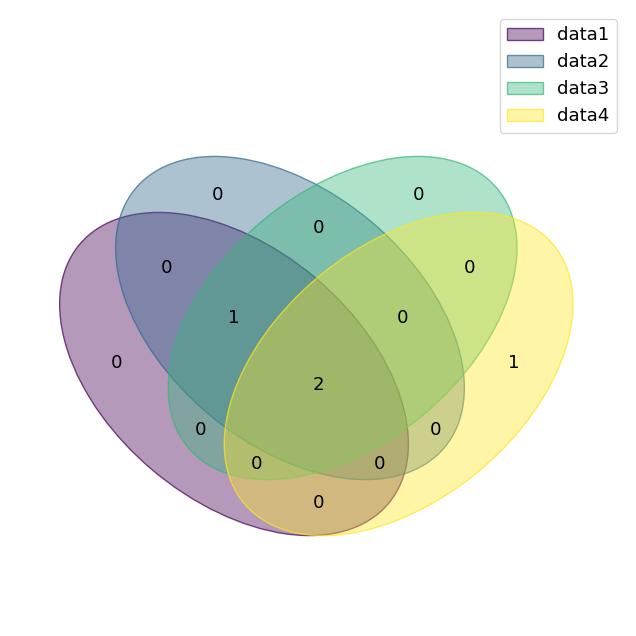

In [ ]:
from venn import venn

venn(
    {
        "data1": {"A", "B", "C"},
        "data2": {"A", "B", "C"},
        "data3": {"A", "B", "C"},
        "data4": {"A", "B", "D"},
    }
)

In [ ]:
from_contents(
    {
        "data1": {"A", "B", "C"},
        "data2": {"A", "B", "C"},
        "data3": {"A", "B", "C"},
        "data4": {"A", "B", "D"},
    }
)

id
data1 data2 data3 data4   
True  True  True  True   A
                  False  C
                  True   B
False False False True   D

#### Transmembrane transporters

About 21% of transmembrane annotations only occur in the keywords dataset. These could, however, also be outliers, as the keyword filtering is less precise.

The largest overlap is between GO-Uniprot and Keywords, with 44% of all potential transporters in that dataset.

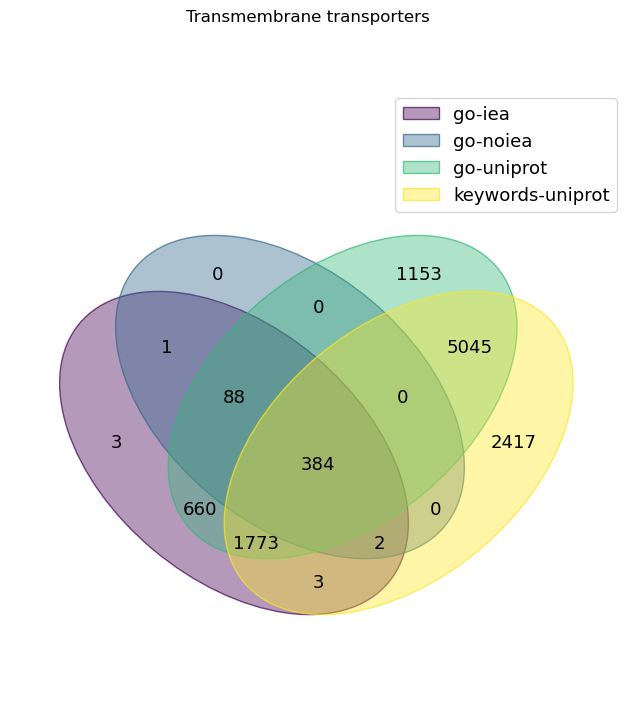

In [ ]:
venn(
    {
        "go-iea": go_iea_transmembranetransport,
        "go-noiea": go_noiea_transmembranetransport,
        "go-uniprot": go_uniprot_transmembranetransport,
        "keywords-uniprot": keywords_transmembranetransport,
    }
)
plt.suptitle("Transmembrane transporters")
plt.show()


#### Amino-acid transporters

We see a similar pattern for the AA transporters, although this time, the GO-Uniprot contains the largest number of unique terms: 

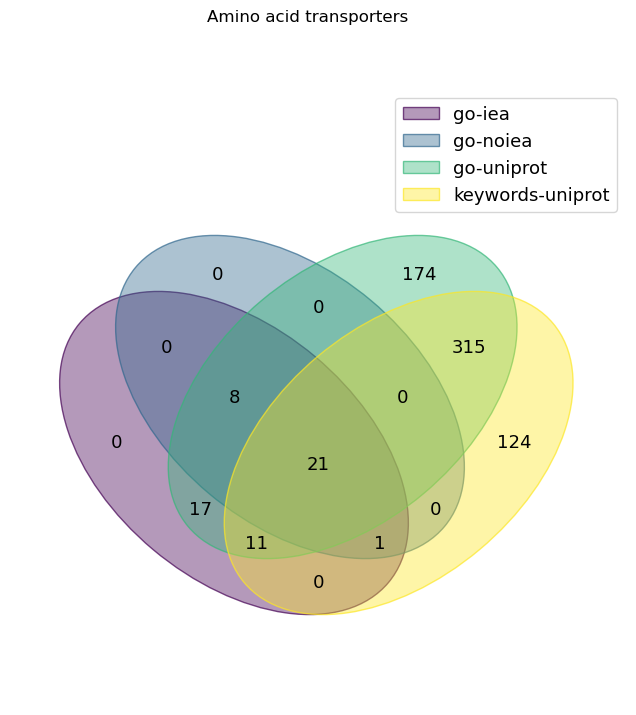

In [ ]:
venn(
    {
        "go-iea": go_iea_amino,
        "go-noiea": go_noiea_amino,
        "go-uniprot": go_uniprot_amino,
        "keywords-uniprot": keywords_amino,
    }
)
plt.suptitle("Amino acid transporters")
plt.show()


#### Carbohydrate Transporters

With carbohydrate, the Keywords dataset contains the largest share of unique proteins again. The largest overlap is again with GO-Uniprot.

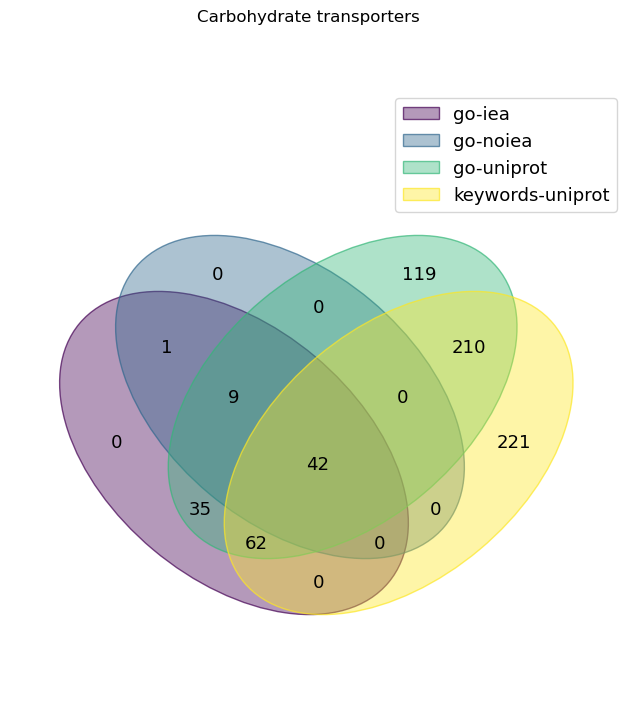

In [ ]:
venn(
    {
        "go-iea": go_iea_carbo,
        "go-noiea": go_noiea_carbo,
        "go-uniprot": go_uniprot_carbo,
        "keywords-uniprot": keywords_carbo,
    }
)
plt.suptitle("Carbohydrate transporters")
plt.show()


#### Sugar

50% of all sugar transporters are only available in the keywords database. GO terms add only 8%. 

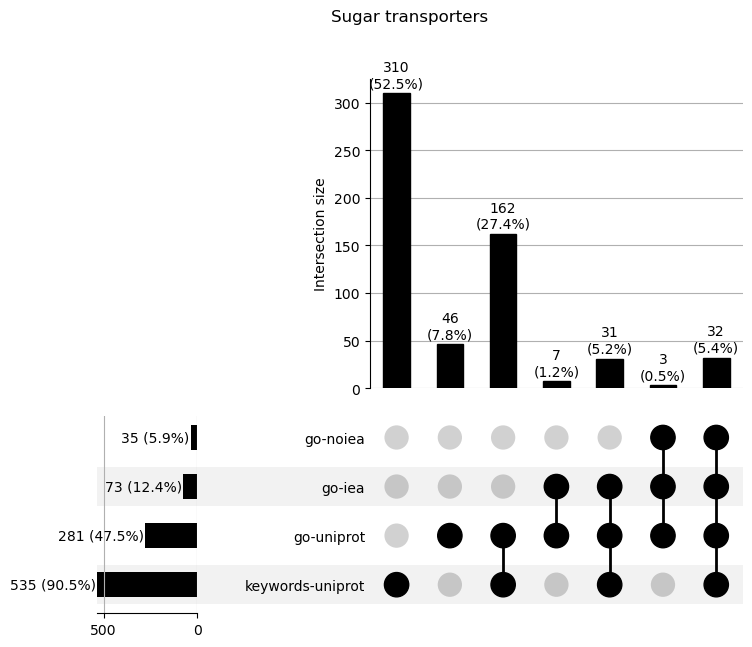

In [ ]:
upset(
    {
        "go-iea": go_iea_sugar,
        "go-noiea": go_noiea_sugar,
        "go-uniprot": go_uniprot_sugar,
        "keywords-uniprot": keywords_sugar,
    }
)
plt.suptitle("Sugar transporters")
plt.show()


Maybe we should sample some of the proteins that do not have GO terms. Are they outliers, like proteins that are only associated with Sugar transport but do not carry it out?

Here are the keyword-only Sugar transporters:

In [ ]:
proteins_only_keyword_sugar = (
    (keywords_sugar - go_uniprot_sugar) - go_iea_sugar
) - go_noiea_sugar

for protein_name in df_swissprot.loc[proteins_only_keyword_sugar].protein_names:
    print(protein_name)


Probable sugar phosphate/phosphate translocator At3g17430
Sodium/myo-inositol cotransporter 2 (Na(+)/myo-inositol cotransporter 2) (Sodium/myo-inositol transporter 2) (SMIT2) (Solute carrier family 5 member 11)
High glucose sensor RGT2 (Low-affinity glucose receptor RGT2) (Low-affinity transporter-like sensor RGT2) (Restores glucose transport protein 2)
UDP-xylose and UDP-N-acetylglucosamine transporter (Solute carrier family 35 member B4)
PTS system sorbose-specific EIID component (EIID-Sor) (Sorbose permease IID component)
Xylose/arabinose import permease protein XacH
Glucose transporter 1B/1C/1D/1F/2B
Probable sugar phosphate/phosphate translocator At5g25400
Phosphoenolpyruvate/phosphate translocator 2, chloroplastic (AtPPT2)
GDP-mannose transporter 2 (GMT 2)
Probable UDP-sugar transporter protein SLC35A4 (Solute carrier family 35 member A4)
Solute carrier family 35 member B1
High-affinity gluconate transporter (Gluconate permease 3) (Gnt-III system)
Probable UDP-sugar transporter p

/tmp/ipykernel_72316/512618924.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for protein_name in df_swissprot.loc[proteins_only_keyword_sugar].protein_names:


In this sample, we do find many proteins that are actual sugar transporters, so it's not all outliers.

However, there are also components of complexes, as well as upstream proteins like sugar sensors that regulate sugar transporter expression.

There is also a number of "probable tranporters". 

Using keywords does give us more samples, but the problem is that the Sugar transport keyword is a Biological Process keyword, and also contains upstream and downstream proteins. Using the Transmembrane keyword filters out most of the wrong samples, but not all of them.

#### Ion transporters

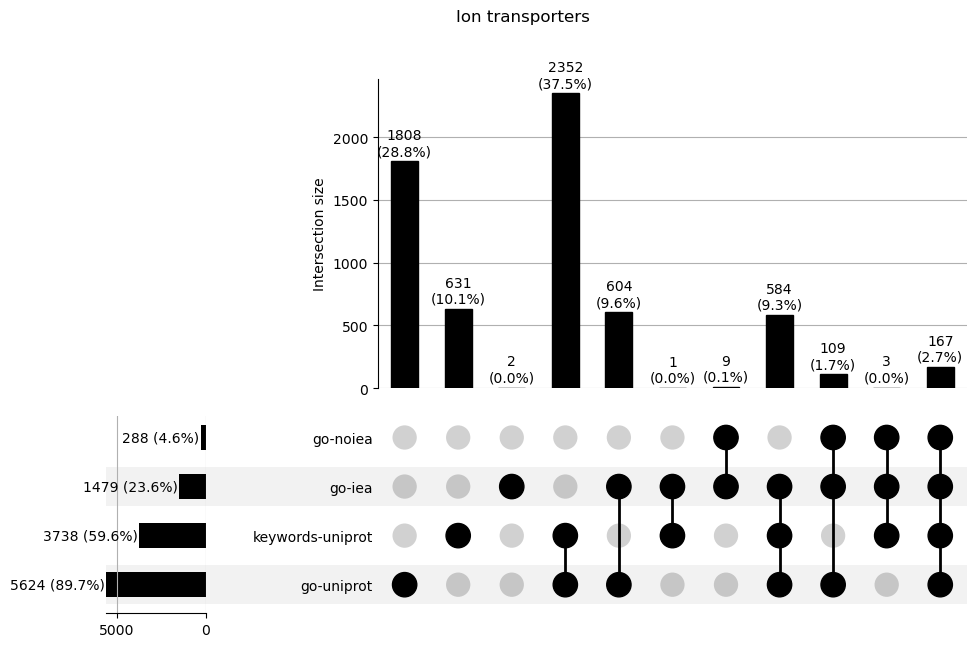

In [ ]:
upset(
    {
        "go-iea": go_iea_ion,
        "go-noiea": go_noiea_ion,
        "go-uniprot": go_uniprot_ion,
        "keywords-uniprot": keywords_ion,
    }
)
plt.suptitle("Ion transporters")
plt.show()


In [ ]:
df_go_all_trembl = df_go_all[
    df_go_all.Uniprot.isin(df_sp_kw.Uniprot) | df_go_all.Uniprot.isin(df_sp_go.Uniprot)
]
df_go_all_trembl


,Uniprot,go_id,evidence_code
870,T2KLZ8,GO:0016491,IEA
871,T2KLZ8,GO:0016491,IEA
872,T2KLZ8,GO:0047001,IEA
873,T2KLZ8,GO:0047001,IEA
7705,Q26972,GO:0030215,IEA
...,...,...,...
465763746,Q02322,GO:0016787,IEA
465763747,Q02322,GO:0005524,IEA
465763748,Q02322,GO:0004386,IEA
465763749,Q02322,GO:0042802,IPI


## Results

